In [4]:
import pandas as pd
import numpy as np
import nltk, re
nltk.download('stopwords') # load english stopwords
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter("ignore")
warnings.warn("deprecated", DeprecationWarning)
warnings.simplefilter("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
from zipfile import ZipFile
file_name="/content/drive/My Drive/Colab Notebooks/Assignment 8(sentiment prediction)/Project_1.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [5]:
train= pd.read_csv(r"/content/train.csv")

In [47]:
test= pd.read_csv(r"/content/test.csv")

In [58]:
train.head()

,User_ID,Description,Browser_Used,Device_Used,Is_Response
0,id10326,The room was kind of clean but had a VERY stro...,Edge,Mobile,not happy
1,id10327,I stayed at the Crown Plaza April -- - April -...,Internet Explorer,Mobile,not happy
2,id10328,I booked this hotel through Hotwire at the low...,Mozilla,Tablet,not happy
3,id10329,Stayed here with husband and sons on the way t...,InternetExplorer,Desktop,happy
4,id10330,My girlfriends and I stayed here to celebrate ...,Edge,Tablet,not happy


In [59]:
import seaborn as sns
train['Is_Response'].value_counts()

happy        26521
not happy    12411
Name: Is_Response, dtype: int64

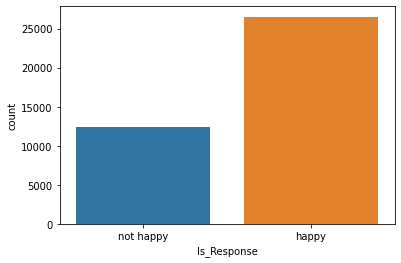

In [73]:
sns.countplot(x=train['Is_Response'])

Almost double the no of happy people than unhappy 

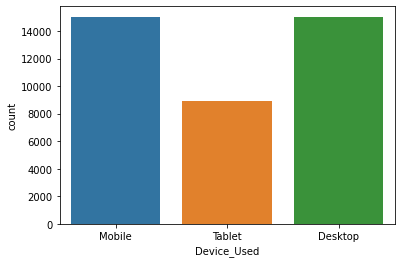

In [65]:
sns.countplot(train['Device_Used'])

Most of the the people uses mobile or destop to write review

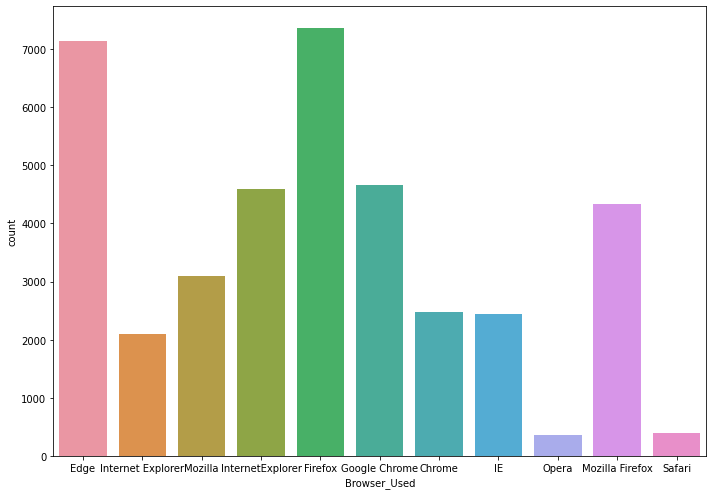

In [71]:
a4_dims = (11.7, 8.27)
from matplotlib import pyplot

fig, ax = pyplot.subplots(figsize=a4_dims)
sns.countplot(ax=ax,x=train['Browser_Used'])

Most  no of people using Mozilla	Firefox 

In [ ]:
#!pip install lightgbm

In [8]:
# 70-30% random split of dataset
X_train, X_test, y_train, y_test = train_test_split(train['Description'].values, train['Is_Response'].values, test_size=0.2, random_state=42)


In [9]:
X_train= train["Description"].values
y_train= train["Is_Response"].values

In [10]:
y_train

array(['not happy', 'not happy', 'not happy', ..., 'not happy',
       'not happy', 'happy'], dtype=object)

In [11]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = list((stopwords.words('english')))

def text_prepare(text,join_sumbol):
    """
        text: a string
        
        return: modified initial string
    """
    # lowercase text
    
    text = text.lower() 

    # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = re.sub(REPLACE_BY_SPACE_RE," ",text,)

    # delete symbols which are in BAD_SYMBOLS_RE from text
    text = re.sub(BAD_SYMBOLS_RE,"",text)
    text = re.sub(r'\s+'," ",text)

    # delete stopwords from text
    text = f'{join_sumbol}'.join([i for i in text.split() if i not in STOPWORDS])
    
    return text

tests = ["SQL Server - any equivalent of Excel's CHOOSE function?",
        "How to free c++ memory vector<int> * arr?"]
for test in tests: print(text_prepare(test,' '))

sql server equivalent excels choose function
free c++ memory vectorint arr


In [12]:
X_train = [text_prepare(x,' ') for x in X_train]
X_test = [text_prepare(x,' ') for x in X_test]
#y_train = [text_prepare(x,',') for x in y_train]
#y_test = [text_prepare(x,',') for x in y_test]

In [13]:
from collections import Counter
from itertools import chain

# Dictionary of all tags from train corpus with their counts.
tags_counts = Counter(chain.from_iterable([i.split(",") for i in y_train]))

# Dictionary of all words from train corpus with their counts.
words_counts = Counter(chain.from_iterable([i.split(" ") for i in X_train]))

top_3_most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)[:3]
top_3_most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:3]

print(f"Top three most popular tags are: {','.join(tag for tag, _ in top_3_most_common_tags)}")
print(f"Top three most popular words are: {','.join(tag for tag, _ in top_3_most_common_words)}")

Top three most popular tags are: happy,not happy
Top three most popular words are: hotel,room,stay


In [14]:
# We considered only the top 5,000 words, this parameter can be fine-tuned
DICT_SIZE = 5000
WORDS_TO_INDEX = {j[0]:i for i,j in enumerate(sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:DICT_SIZE])}
INDEX_TO_WORDS = {i:j[0] for i,j in enumerate(sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:DICT_SIZE])}
ALL_WORDS = WORDS_TO_INDEX.keys()

def my_bag_of_words(text, words_to_index, dict_size):
    """
        text: a string
        dict_size: size of the dictionary
        
        return a vector which is a bag-of-words representation of 'text'
    """
    result_vector = np.zeros(dict_size)
    keys= [words_to_index[i] for i in text.split(" ") if i in words_to_index.keys()]
    result_vector[keys]=1
    return result_vector

In [15]:
from scipy import sparse as sp_sparse

In [16]:
X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])
print('X_train shape ', X_train_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

X_train shape  (38932, 5000)
X_test shape  (7787, 5000)


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_features(X_train, X_test):
    """
        X_train, X_val, X_test — samples        
        return bag-of-words representation of each sample and vocabulary
    """
    # Create TF-IDF vectorizer with a proper parameters choice
    # Fit the vectorizer on the train set
    # Transform the train, test, and val sets and return the result
    
    
    tfidf_vectorizer = TfidfVectorizer(X_train,ngram_range=(1,2),max_df=0.9,min_df=5,token_pattern=r'(\S+)' )
    tfidf_vectorizer.fit(X_train)
    X_train = tfidf_vectorizer.transform(X_train)
    X_test = tfidf_vectorizer.transform(X_test)
    
    return X_train, X_test, tfidf_vectorizer.vocabulary_

X_train_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [ ]:
#!pip install lightgbm

In [20]:
# For multiclass classification
from sklearn.multiclass import OneVsRestClassifier

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
#from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier

def train_classifier(X_train, y_train, X_valid=None, y_valid=None, C=1.0, model='lr'):
    """
      X_train, y_train — training data
      
      return: trained classifier
      
    """
    
    if model=='lr':
        model = LogisticRegression(C=C, penalty='l1', dual=False, solver='liblinear')
        #model = OneVsRestClassifier(model)
        model.fit(X_train, y_train)
    
    elif model=='svm':
        model = LinearSVC(C=C, penalty='l1', dual=False, loss='squared_hinge')
        #model = OneVsRestClassifier(model)
        model.fit(X_train, y_train)
    
    elif model=='nbayes':
        model = MultinomialNB(alpha=1.0)
        #model = OneVsRestClassifier(model)
        model.fit(X_train, y_train)
        
    elif model=='sdg':
        model = SGDClassifier(loss='hinge')
        #model = OneVsRestClassifier(model)
        model.fit(X_train, y_train)

    return model

# Train the classifiers for different data transformations: bag-of-words and tf-idf.

# Linear NLP model using bag of words approach
%time classifier_mybag = train_classifier(X_train_mybag, y_train, C=1.0, model='nbayes')

# Linear NLP model using TF-IDF approach
%time classifier_tfidf = train_classifier(X_train_tfidf, y_train, C=1.0, model='nbayes')

CPU times: user 118 ms, sys: 3 ms, total: 121 ms
Wall time: 126 ms
CPU times: user 144 ms, sys: 989 µs, total: 145 ms
Wall time: 144 ms


In [21]:
y_test_predicted_labels_mybag = classifier_mybag.predict(X_test_mybag)

y_test_predicted_labels_tfidf = classifier_tfidf.predict(X_test_tfidf)

In [22]:
y_test_pred_inversed = y_test_predicted_labels_tfidf
y_test_inversed = y_test
for i in range(3):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_test[i],
        ','.join(y_test_inversed[i]),
        ','.join(y_test_pred_inversed[i])
    ))

Title:	arrived received upgraded room charge construction across street disruptive went spoke jennifer front desk immediately offered give us another room located end hotel personally showed us room ensure happy also helpful recommending local shows attractions thank jennifer
True labels:	h,a,p,p,y
Predicted labels:	h,a,p,p,y


Title:	read reviews affinia gardens good really wasnt sure expect boy pleasantly surprised first room immaculate little fussy comes cleanliness place spotless four ladies sharing room recipe distaster right room different areas makeup area separate mirror near bathroom kitchenette wonderful bagel coffee left classes reason didnt rank five location take cab times square place real gem
True labels:	h,a,p,p,y
Predicted labels:	h,a,p,p,y


Title:	new husband stayed hotel th november nights booked hotel direct based reasonable room rate nyc excellent reviews tripadvisor arrived yellow cab greeted lovely welcoming staff advised upon booking almost year departing would

In [23]:
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [24]:
print('\t\t\t\tCLASSIFICATIION METRICS TF-IDF\n')
print(metrics.classification_report(y_test,  y_test_pred_inversed
                                    ))

				CLASSIFICATIION METRICS TF-IDF

              precision    recall  f1-score   support

       happy       0.86      0.99      0.92      5285
   not happy       0.96      0.65      0.78      2502

    accuracy                           0.88      7787
   macro avg       0.91      0.82      0.85      7787
weighted avg       0.89      0.88      0.87      7787



In [27]:
# Final model
C = 0.7
classifier = train_classifier(X_train_tfidf, y_train, C=C, model='nbayes')

# Results
test_predictions =  classifier.predict(X_test_tfidf)
test_pred_inversed =test_predictions

test_pred_inversed

array(['happy', 'happy', 'happy', ..., 'happy', 'happy', 'happy'],
      dtype='<U9')

In [28]:
#Creating Pipelines
from sklearn.pipeline import Pipeline

In [30]:
from sklearn.preprocessing import FunctionTransformer
textclf = FunctionTransformer(text_prepare)
tfidf= FunctionTransformer(TfidfVectorizer(X_train,ngram_range=(1,2),max_df=0.9,min_df=5,token_pattern=r'(\S+)' ))

In [31]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

In [32]:
pipeline = Pipeline([
    #('txtcla', textclf),
    ('vect', CountVectorizer(ngram_range=(1,2),max_df=0.9,min_df=5,token_pattern=r'(\S+)')),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC(loss='l2', penalty='l1', dual=False,class_weight='balanced',verbose=0,max_iter=3))
])

In [33]:
param_grid = {
    'vect__max_df':[0.8,0.9,1.0],
    'clf__C':[0.5,0.6,0.7,0.8,0.9,1.0]
}

In [34]:
from sklearn.model_selection import GridSearchCV

In [35]:
grid = GridSearchCV(pipeline,param_grid, n_jobs=-1, verbose=0,refit=True,cv=5)
grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=0.9,
                                                        max_features=None,
                                                        min_df=5,
                                                        ngram_range=(1, 2),
                                                        prep

In [36]:
grid.best_params_

{'clf__C': 0.5, 'vect__max_df': 1.0}

In [37]:
ss=grid.predict(X_test)

In [40]:
print(metrics.classification_report(y_test,  ss
                                    ))

              precision    recall  f1-score   support

       happy       0.96      0.91      0.93      5285
   not happy       0.83      0.91      0.87      2502

    accuracy                           0.91      7787
   macro avg       0.89      0.91      0.90      7787
weighted avg       0.92      0.91      0.91      7787



In [41]:
from sklearn.externals import joblib

In [42]:
joblib.dump(grid.best_estimator_, 'Finalmodel_Pratik.pkl')

['Finalmodel_Pratik.pkl']

In [43]:
h=joblib.load('Finalmodel_Pratik.pkl')

In [52]:
ff= test["Description"]

In [53]:
ff1 = [text_prepare(x,' ') for x in ff]

In [54]:
g=h.predict(ff1)

In [55]:
g

array(['not happy', 'happy', 'happy', ..., 'happy', 'happy', 'happy'],
      dtype=object)

In [56]:
test["Is_Response"]= g

In [57]:
test

,User_ID,Description,Browser_Used,Device_Used,Is_Response
0,id80132,Looking for a motel in close proximity to TV t...,Firefox,Mobile,not happy
1,id80133,Walking distance to Madison Square Garden and ...,InternetExplorer,Desktop,happy
2,id80134,Visited Seattle on business. Spent - nights in...,IE,Tablet,happy
3,id80135,This hotel location is excellent and the rooms...,Edge,Mobile,not happy
4,id80136,This hotel is awesome I love the service Antho...,Mozilla,Mobile,happy
...,...,...,...,...,...
29399,id109531,I stayed at the hotel and towers for a confere...,Chrome,Mobile,happy
29400,id109532,Trying to stay within the Marriott family and ...,Internet Explorer,Tablet,happy
29401,id109533,"We stayed for - nights with our little dog,ver...",Edge,Desktop,happy
29402,id109534,Stayed at the Yotel over the weekend and was v...,InternetExplorer,Desktop,happy
